# To-Do May 15

## Make sure Instagram still works

## HMM!

## Port PCA to csv for use in R, Bayes, etc

## Find out how many individuals are represented in correct vs incorrect predictions
Eg. do we get some users who always show up in false neg or false pos, or in true pos?  
This might be especially useful for the url and created date analyses, where we don't know the extent to which a subset of usernames might be driving correct classification.  
for those in false pos, look at the actual posts (might be easier for twitter), and maybe even have mturk rate whether they seem depressed or not. are we finding new depressed cases, or are we just wrong?  

## Restrict username analysis to only those individuals with a minimum number of days represented in their observations 
Alternately, min number of posts   
See R code notes for more. (bayes.R)

## Move R code to Jupyter?

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [3]:
dbfile = 'project_may9_649pm.db'
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?  
What sort of analyses or models do we want to run?

In [4]:
platform = 'tw'
platform_long = 'twitter'
condition = 'depression'
test_name = 'cesd'
test_cutoff = 21
photos_rated = True
has_test = True
gb_types = ['created_date','weekly','user_id'] # note "weekly" not "post" as in instagram version
periods = ['before','after']
turn_points = ['from_diag','from_susp']
fields = "id, text, has_url"
clfs = ['lr','rf']

report_sample_size = False # simple reporting feature

load_from_pickle = False # loads entire data dict, including masters, from pickle file

final_pickle = True # pickles entire data dict after all masters are created

populate_wordfeats_db = False # generates word features from reagan code

run_master = True 
run_subsets = True
run_separate_pca = False

action_params = {
    'create_master': True, 
    'save_to_file' : True, 
    'density' : False, 
    'ml' : False, 
    'nhst' : False, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': True
}

params = define_params(condition, test_name, test_cutoff, platform, platform_long, fields, photos_rated, has_test)

In [15]:
# printout showing sample sizes for target and control groups
if report_sample_size:
    report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

## Load ready data, or prepare raw data

Set load_from_pickle to determine action here.  

In case you don't have a pickled data dict, or if you want to make a new one, the next block will:

- Pulls data from db
- Aggregates in buckets (day, week, user)
- Creates before/after diag/susp date subsets along with whole

Otherwise we load existing cleaned/aggregated data from pickle

In [10]:
if load_from_pickle:
    data = pickle.load( open( "data.p", "rb" ) )
    
else:
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, periods, turn_points)
    pickle.dump( data, open( "data.p", "wb" ) )
    

TARGET DATA:
Number of tweets with url in text: 0
Adding url tags...
Number of tweets with url in text: 43557
Adding reply tags...
Number of tweets with @ in text: 89391
Adding RT tags...
Number of tweets with RT: 38669

('Subset shape for TW BEFORE FROM_DIAG:', (32303, 15))
('Subset shape for TW BEFORE FROM_SUSP:', (11096, 15))
('Subset shape for TW AFTER FROM_DIAG:', (47499, 15))
('Subset shape for TW AFTER FROM_SUSP:', (16138, 15))

CONTROL DATA:
Number of tweets with url in text: 0
Adding url tags...
Number of tweets with url in text: 37571
Adding reply tags...
Number of tweets with @ in text: 57791
Adding RT tags...
Number of tweets with RT: 19555



### This next section generates word features from Andy Reagan's code

Only set populate_wordfeats_db = True if you need to redo the features for some reason!
    

In [8]:
if populate_wordfeats_db:
    for pop_long in ['target','control']:
        for tunit in ['user_id','created_date','weekly']:

            print 'In {} :: {}'.format(pop_long,tunit)

            create_word_feats(data[pop_long], tunit, condition, conn, write_to_db=True, testing=False)


## Construct master dataset & run analyses

Possible actions:
- generate master data
- save to disk
- plot target vs control densities for each variable
- correlation plot
- ML modeling
- NHST

In [13]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'

    if action_params['create_master']:
        master['model'] = {}

    for gb_type in gb_types:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs)


Merge to master: MAIN created_date
master created_date shape: (34676, 86)


Merge to master: MAIN weekly
master weekly shape: (10622, 86)


Merge to master: MAIN user_id
master user_id shape: (190, 78)



## Subset master actions

Same as above block, but for subsets, eg. target before diag_date vs controls

In [14]:
use_pca = False # should models be fit using orthogonal pca components?

if run_subsets:
    for period in periods:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in turn_points:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{} {}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in gb_types:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {}'.format(period.upper(), turn_point.upper(), gb_type.upper())
                # merge target, control, into master
                master_actions(master, target, control, condition,
                               platform, params, gb_type, report,
                               action_params, clfs, 
                               use_pca=use_pca) # using PCA!

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: CREATED_DATE

Merge to master: before from_diag created_date
master created_date shape: (25948, 86)

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: WEEKLY

Merge to master: before from_diag weekly
master weekly shape: (8420, 86)

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: USER_ID

Merge to master: before from_diag user_id
master user_id shape: (171, 78)

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_SUSP  Groupby: CREATED_DATE

Merge to master: before from_susp created_date
master created_date shape: (20711, 86)

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_SUSP  Groupby: WEEKLY

Merge to master: before from_susp weekly
master weekly shape: (6997, 86)

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_SUSP  Groupby: USER_ID

Merge to master: before from_susp user_id
master user_id shape: (119, 78)

Reporting for: SUBSETS
Period: AFTER  Focus: FROM_DIAG  Groupby: CREAT

In [8]:
if final_pickle:
    pickle.dump( data, open( "data.p", "wb" ) )

### Within-target before vs after

This compares before/after diag/susp dates within target population.  
Basically just a check to see whether the population looks different based on a given change point

In [10]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow

for gb_type in ['created_date','weekly']: 
    before_vs_after(data['target']['gb'], gb_type, platform, condition, params['vars'][platform], action_params)


before vs after (target: depression) for created_date-groupby, based on diag_date:

before vs after (target: depression) for created_date-groupby, based on susp_date:

before vs after (target: depression) for weekly-groupby, based on diag_date:

before vs after (target: depression) for weekly-groupby, based on susp_date:


### PCA

PCA below only runs on master (ie. not before/after diag/susp vs control).

Note: You can fold in PCA into the master_actions() sequence, above, by adding the parameter use_pca=True  
This will only run PCA and PCA components as predictors, though.  
Currently you can't run both PCA and non-PCA when modeling, simulataneously - you did this mainly to cut down on the length of any one given code block output.  
You may find PCA particularly helpful for the timeline groups analysis...

RUNNING PCA: created_date

Total vars: 78
Num components selected by Minka MLE: 77
Cumulative % variance explained per component:
[  56.74   60.82   62.98   64.97   66.71   68.3    69.73   70.98   72.14
   73.24   74.33   75.4    76.42   77.39   78.33   79.24   80.11   80.95
   81.77   82.57   83.32   84.06   84.76   85.45   86.12   86.77   87.4
   88.02   88.62   89.21   89.78   90.32   90.85   91.37   91.87   92.35
   92.82   93.27   93.7    94.1    94.5    94.89   95.27   95.63   95.98
   96.32   96.65   96.95   97.22   97.49   97.75   97.99   98.22   98.44
   98.65   98.84   99.01   99.17   99.32   99.45   99.56   99.66   99.75
   99.8    99.85   99.9    99.93   99.96   99.99  100.    100.01  100.01
  100.01  100.01  100.01  100.01  100.01]


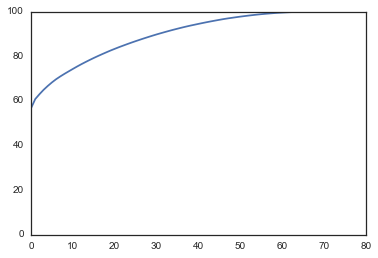

num pca comp displayed: 77
optimal number of components: 69


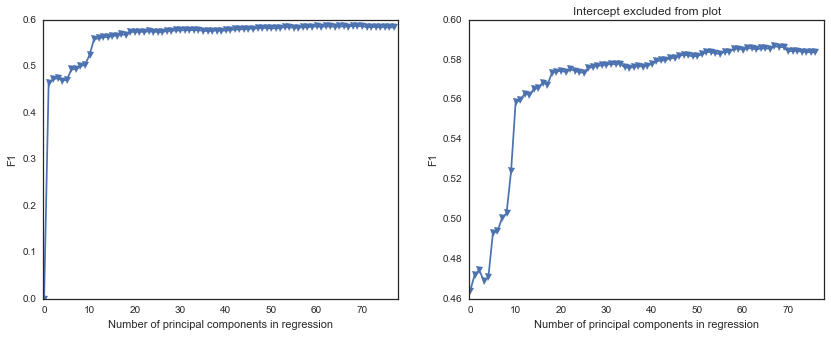

LIWC_total_count    0.147411
LIWC_sad            0.146188
LIWC_humans         0.146087
LIWC_article        0.145730
LabMT_num_words     0.144605
LIWC_ingest         0.142917
LIWC_posemo         0.142450
LIWC_past           0.141636
LIWC_feel           0.141510
LIWC_swear          0.141136
Name: PCA_0, dtype: float64

ANEW_happs        0.489145
ANEW_dominance    0.486844
ANEW_arousal      0.468373
LabMT_happs       0.300377
word_count        0.216863
LIWC_happs        0.201641
LIWC_ipron        0.163557
tweet_count       0.082414
total_words       0.072247
LIWC_conj         0.066009
Name: PCA_1, dtype: float64

is_rt             0.546097
is_reply          0.530619
word_count        0.391906
ANEW_happs        0.174508
ANEW_dominance    0.173077
ANEW_arousal      0.161433
LIWC_i            0.149144
LIWC_ipron        0.147242
tweet_count       0.121148
LIWC_we           0.118963
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DAT

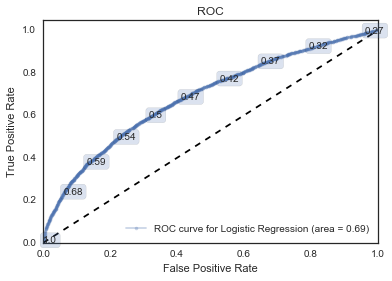

MODEL: Random Forests target (Models: PCA MAIN created_date):
NAIVE ACCURACY: 0.648

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          3773         1640
known_target           2021         2969

Proportion of pred_target in known_control: 0.303
Proportion of pred_target in known_target: 0.595




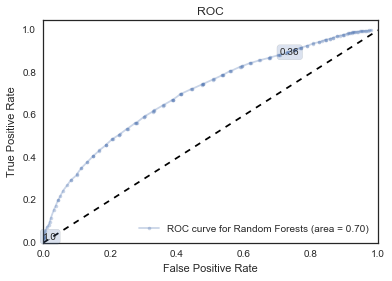

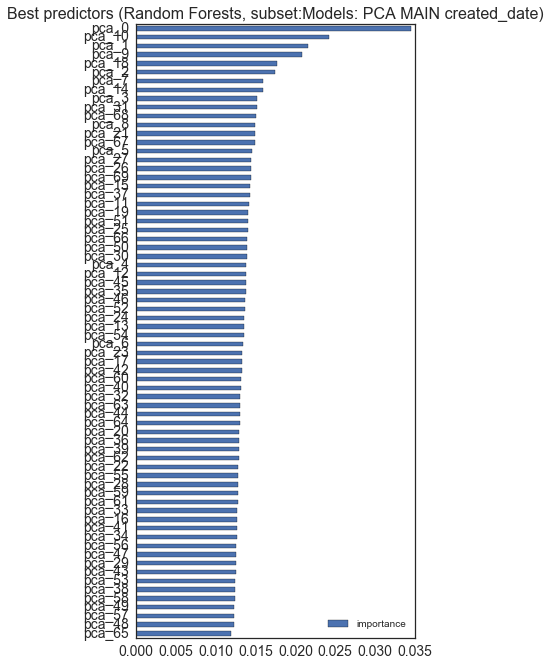

RUNNING PCA: weekly

Total vars: 78
Num components selected by Minka MLE: 77
Cumulative % variance explained per component:
[  68.07   72.29   74.48   76.55   78.03   79.39   80.52   81.6    82.62
   83.48   84.28   85.05   85.79   86.5    87.18   87.83   88.45   89.04
   89.55   90.05   90.52   90.98   91.43   91.84   92.25   92.65   93.03
   93.39   93.75   94.08   94.4    94.72   95.02   95.31   95.58   95.85
   96.11   96.35   96.59   96.82   97.05   97.25   97.45   97.64   97.82
   98.     98.17   98.33   98.48   98.63   98.77   98.9    99.02   99.14
   99.25   99.35   99.45   99.54   99.63   99.71   99.78   99.84   99.89
   99.92   99.95   99.97   99.99  100.01  100.02  100.03  100.03  100.03
  100.03  100.03  100.03  100.03  100.03]


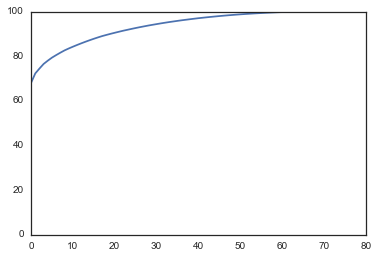

num pca comp displayed: 77
optimal number of components: 57


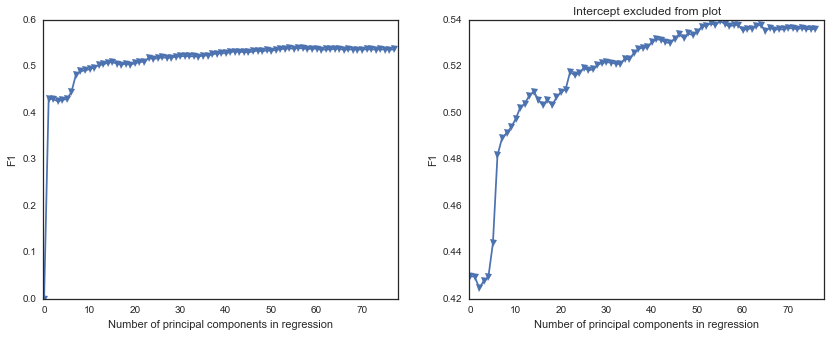

LIWC_sad            0.135537
LIWC_humans         0.135468
LIWC_article        0.134944
LIWC_total_count    0.134445
LIWC_ingest         0.134198
LIWC_posemo         0.134072
LIWC_feel           0.133844
LIWC_swear          0.133385
LabMT_num_words     0.132939
LIWC_past           0.132812
Name: PCA_0, dtype: float64

ANEW_happs        0.488178
ANEW_dominance    0.486893
ANEW_arousal      0.467220
LabMT_happs       0.282875
LIWC_happs        0.203151
LIWC_ipron        0.201002
word_count        0.193061
tweet_count       0.104953
total_words       0.104351
LIWC_ppron        0.087915
Name: PCA_1, dtype: float64

is_reply       0.364937
is_rt          0.332583
word_count     0.316384
has_url        0.298900
tweet_count    0.268908
total_words    0.262678
LIWC_happs     0.227172
LabMT_happs    0.178842
LIWC_ipron     0.161065
ANEW_happs     0.150277
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY
NAIVE ACCURACY ALL NULL: 0.593
  *

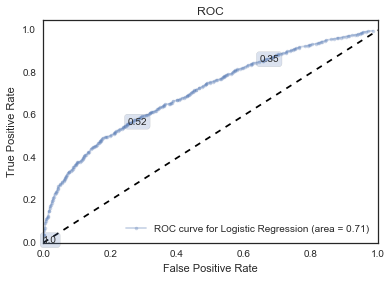

MODEL: Random Forests target (Models: PCA MAIN weekly):
NAIVE ACCURACY: 0.682

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1592          299
known_target            715          581

Proportion of pred_target in known_control: 0.158
Proportion of pred_target in known_target: 0.448




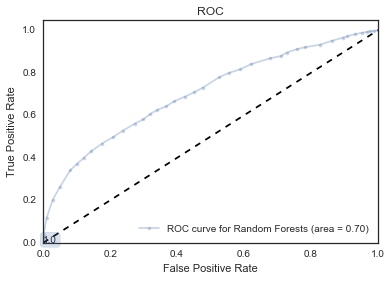

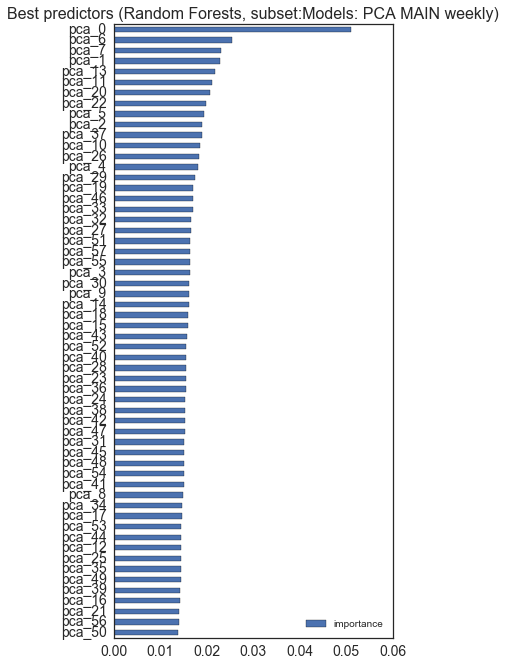

RUNNING PCA: user_id

Total vars: 74
Num components selected by Minka MLE: 73
Cumulative % variance explained per component:
[  78.96   84.01   86.47   88.49   89.81   90.9    91.88   92.7    93.32
   93.93   94.44   94.88   95.26   95.62   95.95   96.23   96.5    96.74
   96.95   97.15   97.35   97.54   97.72   97.88   98.02   98.16   98.29
   98.42   98.53   98.63   98.72   98.81   98.9    98.98   99.06   99.13
   99.2    99.26   99.32   99.38   99.43   99.48   99.53   99.57   99.61
   99.65   99.69   99.72   99.75   99.78   99.81   99.84   99.86   99.88
   99.9    99.92   99.94   99.96   99.97   99.98   99.99  100.    100.01
  100.01  100.01  100.01  100.01  100.01  100.01  100.01  100.01  100.01
  100.01]


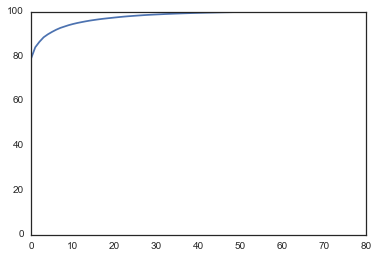

num pca comp displayed: 73
optimal number of components: 20


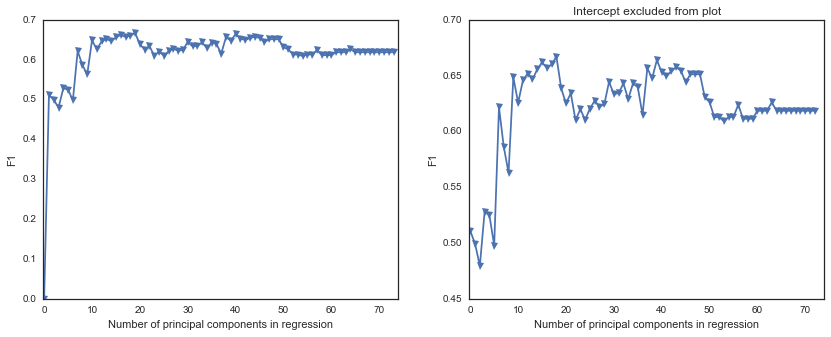

LIWC_sad        0.130099
LIWC_humans     0.130019
LIWC_article    0.129800
LIWC_swear      0.129573
LIWC_affect     0.129423
LIWC_ingest     0.129419
LIWC_posemo     0.129374
LIWC_feel       0.129307
LIWC_excl       0.129256
LIWC_body       0.128913
Name: PCA_0, dtype: float64

ANEW_dominance    0.487437
LabMT_happs       0.477147
ANEW_happs        0.450932
ANEW_arousal      0.440259
LIWC_happs        0.218154
has_url           0.163899
word_count        0.159521
LIWC_ipron        0.128353
is_rt             0.056857
LIWC_inhib        0.053580
Name: PCA_1, dtype: float64

is_reply        0.525542
is_rt           0.448321
word_count      0.339506
has_url         0.330134
tweet_count     0.249468
LIWC_ipron      0.172141
LIWC_happs      0.122523
LIWC_shehe      0.113790
LIWC_you        0.111454
ANEW_arousal    0.101353
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USER_ID
NAIVE ACCURACY ALL NULL: 0.509
  *'ALL NULL' means if all obser

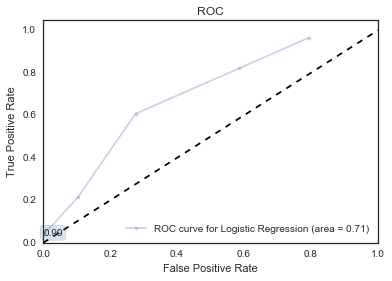

MODEL: Random Forests target (Models: PCA MAIN user_id):
NAIVE ACCURACY: 0.649

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            18           11
known_target              9           19

Proportion of pred_target in known_control: 0.379
Proportion of pred_target in known_target: 0.679




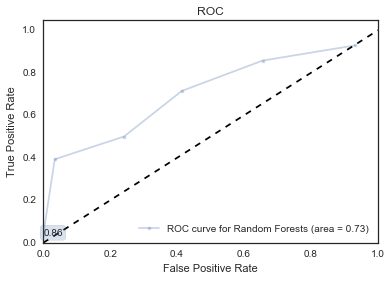

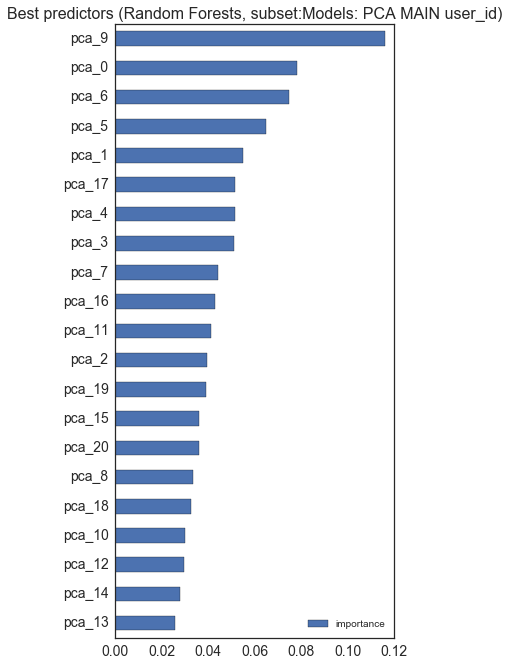

In [12]:
if run_separate_pca:
    master = data['master']
    report = 'PCA MAIN'
    clfs = ['lr','rf']

    for gb_type in ['created_date','weekly','user_id']:

        print 'RUNNING PCA: {}'.format(gb_type)
        print
        model_df = {'name':'Models: {} {}'.format(report, gb_type),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][platform][gb_type]['means'],
                    'target':'target',
                    'platform':platform,
                    'tall_plot':action_params['tall_plot']
                   }

        excluded_set = params['model_vars_excluded'][platform][gb_type]

        _, pcafit = make_models(model_df, 
                    clf_types=clfs, excluded_set=excluded_set, 
                    tall_plot=model_df['tall_plot'], 
                    use_pca=True)